### link_to_view_the_model_performance: https://www.linkedin.com/posts/hui-liu-3b705a245_yolov8-computervision-maskdetection-activity-7028596212161265664-y2RQ?utm_source=share&utm_medium=member_desktop

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

### some imports

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import random
import shutil
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import PIL
import os
from PIL import Image

In [3]:
root_dir = '/kaggle/input/face-mask-detection'
annot_dir = os.path.join(root_dir, 'annotations')
img_dir = os.path.join(root_dir, 'images')

### extract information from the annotation files

In [4]:
dataset = {'filename':[],
           'mask_or_not':[],
           'width':[],
           'height':[],
           'xmin':[],
           'ymin':[],
           'xmax':[],
           'ymax':[]
           }

In [5]:
for annot in glob(annot_dir+'/*.xml'):
    tree = ET.parse(annot)
    for element in tree.iter(): # iterate info for all the faces from all the images
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag:
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))
        
        if 'object' in element.tag:
            for attribute in list(element):
                if 'name' in attribute.tag:
                    name = attribute.text
                    dataset['mask_or_not']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height]
                    dataset['filename']+=[annot.split('/')[-1][0:-4]]
                
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            dataset['ymin']+=[ymin]
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            dataset['xmax']+=[xmax]
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            dataset['ymax']+=[ymax]

In [6]:
df = pd.DataFrame(dataset)
df.shape

(4072, 8)

In [7]:
df.head(5)

,filename,mask_or_not,width,height,xmin,ymin,xmax,ymax
0,maksssksksss737,with_mask,400,226,28,55,46,71
1,maksssksksss737,with_mask,400,226,98,62,111,78
2,maksssksksss737,mask_weared_incorrect,400,226,159,50,193,90
3,maksssksksss737,with_mask,400,226,293,59,313,80
4,maksssksksss737,with_mask,400,226,352,51,372,72


### visualize the classes distribution

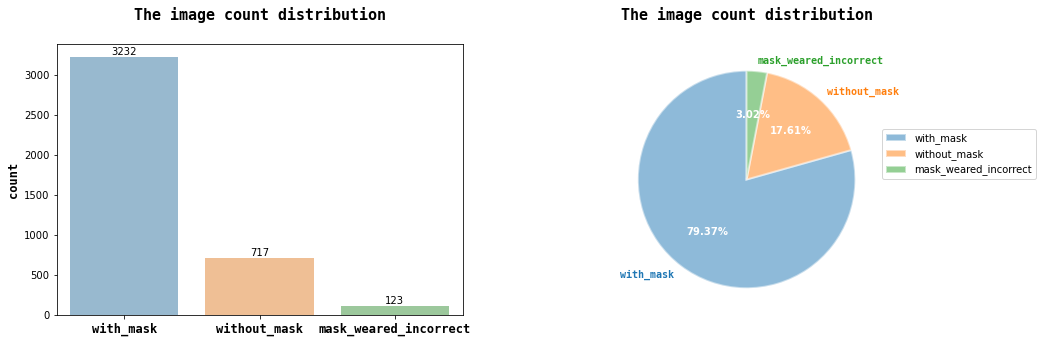

In [8]:
fig,axes = plt.subplots(1,2,figsize=(16,5))
sns.barplot(data=df['mask_or_not'].value_counts().reset_index(), x='index', y='mask_or_not',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)
    
axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(df['mask_or_not'].value_counts().reset_index()['mask_or_not'], labels=df['mask_or_not'].value_counts().reset_index()['index'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

In [9]:
scale = {'with_mask':0, 'without_mask':1, 'mask_weared_incorrect':2}

In [10]:
df['classes'] = df['mask_or_not'].replace(scale)

In [11]:
df.head()

,filename,mask_or_not,width,height,xmin,ymin,xmax,ymax,classes
0,maksssksksss737,with_mask,400,226,28,55,46,71,0
1,maksssksksss737,with_mask,400,226,98,62,111,78,0
2,maksssksksss737,mask_weared_incorrect,400,226,159,50,193,90,2
3,maksssksksss737,with_mask,400,226,293,59,313,80,0
4,maksssksksss737,with_mask,400,226,352,51,372,72,0


### create the necessary dictionaries

In [12]:
base_dir = os.path.join('Mask_Detection')
train_dir = os.path.join(base_dir, 'train')
train_imgs_dir = os.path.join(train_dir, 'images')
train_labels_dir = os.path.join(train_dir, 'labels')

validation_dir = os.path.join(base_dir, 'validation')
validation_imgs_dir = os.path.join(validation_dir, 'images')
validation_labels_dir = os.path.join(validation_dir, 'labels')

test_dir = os.path.join(base_dir, 'test')
test_imgs_dir = os.path.join(test_dir, 'images')
test_labels_dir = os.path.join(test_dir, 'labels')

In [13]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [14]:
create_dir(base_dir)

create_dir(train_dir)
create_dir(train_imgs_dir)
create_dir(train_labels_dir)

create_dir(validation_dir)
create_dir(validation_imgs_dir)
create_dir(validation_labels_dir)

create_dir(test_dir)
create_dir(test_imgs_dir)
create_dir(test_labels_dir)

### train, val , test splits

In [15]:
all_imgs = os.listdir(img_dir)
print(f'There are totally {len(all_imgs)} images ')

There are totally 853 images 


In [16]:
train, test = train_test_split(all_imgs, test_size=0.1)
train, validation = train_test_split(train, test_size=0.15)

In [17]:
print(f'There are {len(train)} images in the train set\n')
print(f'There are {len(validation)} images in the train set\n')
print(f'There are {len(test)} images in the train set')

There are 651 images in the train set

There are 116 images in the train set

There are 86 images in the train set


### distribute the images

In [18]:
def copy_images(source_path, destination_path, copied_images):
    for img in copied_images:
        image = PIL.Image.open(os.path.join(source_path, img))
        _ = image.save(os.path.join(destination_path, img))

In [19]:
copy_images(img_dir,train_imgs_dir, train)
copy_images(img_dir,validation_imgs_dir, validation)
copy_images(img_dir,test_imgs_dir, test)

In [20]:
print(f'There are {len(os.listdir(train_imgs_dir))} images in the train set\n')
print(f'There are {len(os.listdir(validation_imgs_dir))} images in the train set\n')
print(f'There are {len(os.listdir(test_imgs_dir))} images in the train set') 
# as we can see now we have splited the images data

There are 651 images in the train set

There are 116 images in the train set

There are 86 images in the train set


In [21]:
df[['width','height','xmin', 'ymin', 'xmax', 'ymax']] = df[['width','height','xmin', 'ymin', 'xmax', 'ymax']].astype(int)

In [22]:
df['x_center'] = (df['xmin']+df['xmax'])/(2*df['width'])
df['y_center'] = (df['ymin']+df['ymax'])/(2*df['height'])
df['box_width'] = (df['xmax']-df['xmin'])/df['width']
df['box_height'] = (df['ymax']-df['ymin'])/df['height']

In [23]:
df = df.astype(str)

### create labels for all the images

In [24]:
def copy_label(label_list, destination_path):
    for filename in [x.split('.')[0] for x in label_list]:
        data = df[df['filename']==filename]
        
        text_list = []
        for index, row in data.iterrows():
            text_list.append(row['classes']+' '+row['x_center']+' '+row['y_center']+' '+row['box_width']+' '+row['box_height'])
            
            text = '\n'.join(text_list)
            with open (os.path.join(destination_path, filename+'.txt'),'w') as file:
                file.write(text) 

In [25]:
copy_label(train, train_labels_dir)
copy_label(validation, validation_labels_dir)
copy_label(test, test_labels_dir)

In [26]:
print(f'There are {len(os.listdir(train_labels_dir))} images in the train set\n')
print(f'There are {len(os.listdir(validation_labels_dir))} images in the train set\n')
print(f'There are {len(os.listdir(test_labels_dir))} images in the train set') 

There are 651 images in the train set

There are 116 images in the train set

There are 86 images in the train set


### make the data.yaml file

In [27]:
yaml_file = """names: 
- with_mask 
- without_mask 
- mask_weared_incorrect
nc: 3
test: /kaggle/working/Mask_Detection/test/images
train: /kaggle/working/Mask_Detection/train/images
val: /kaggle/working/Mask_Detection/validation/images
"""

with open('Mask_Detection/data_1.yaml', 'w') as f:
    f.write(yaml_file)

### train the yolo v8 model

In [28]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.5/272.5 kB 484.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 9.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
Note: you may need to restart the kernel to use updated packages.


In [29]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output
! yolo checks

Ultralytics YOLOv8.0.29 🚀 Python-3.7.12 torch-1.11.0+cpu CPU
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 4221.3/8062.4 GB disk)


In [30]:
conda install pytorch torchvision torchaudio -c pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    ffmpeg-4.3                 |       hf484d3e_0         9.9 MB  pytorch
    gmp-6.2.1                  |       h58526e2_0         806 KB  conda-forge
    gnutls-3.6.13              |       h85f3911_1         2.0 MB  conda-forge
    lame-3.100                 |    h166bdaf_1003         496 KB  conda-forge
    libblas-3.9.0              |   16_linux64_mkl          13 KB  conda-forge
    libcblas-3.9.0             |   16_linux64_mkl          

In [31]:
! yolo task=detect mode=train model=yolov8x.pt data=/kaggle/working/Mask_Detection/data_1.yaml epochs=7 imgsz=640

100%|████████████████████████████████████████| 131M/131M [00:07<00:00, 18.6MB/s]
Ultralytics YOLOv8.0.29 🚀 Python-3.7.12 torch-1.13.1 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/Mask_Detection/data_1.yaml, epochs=7, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=

### visualize the training results

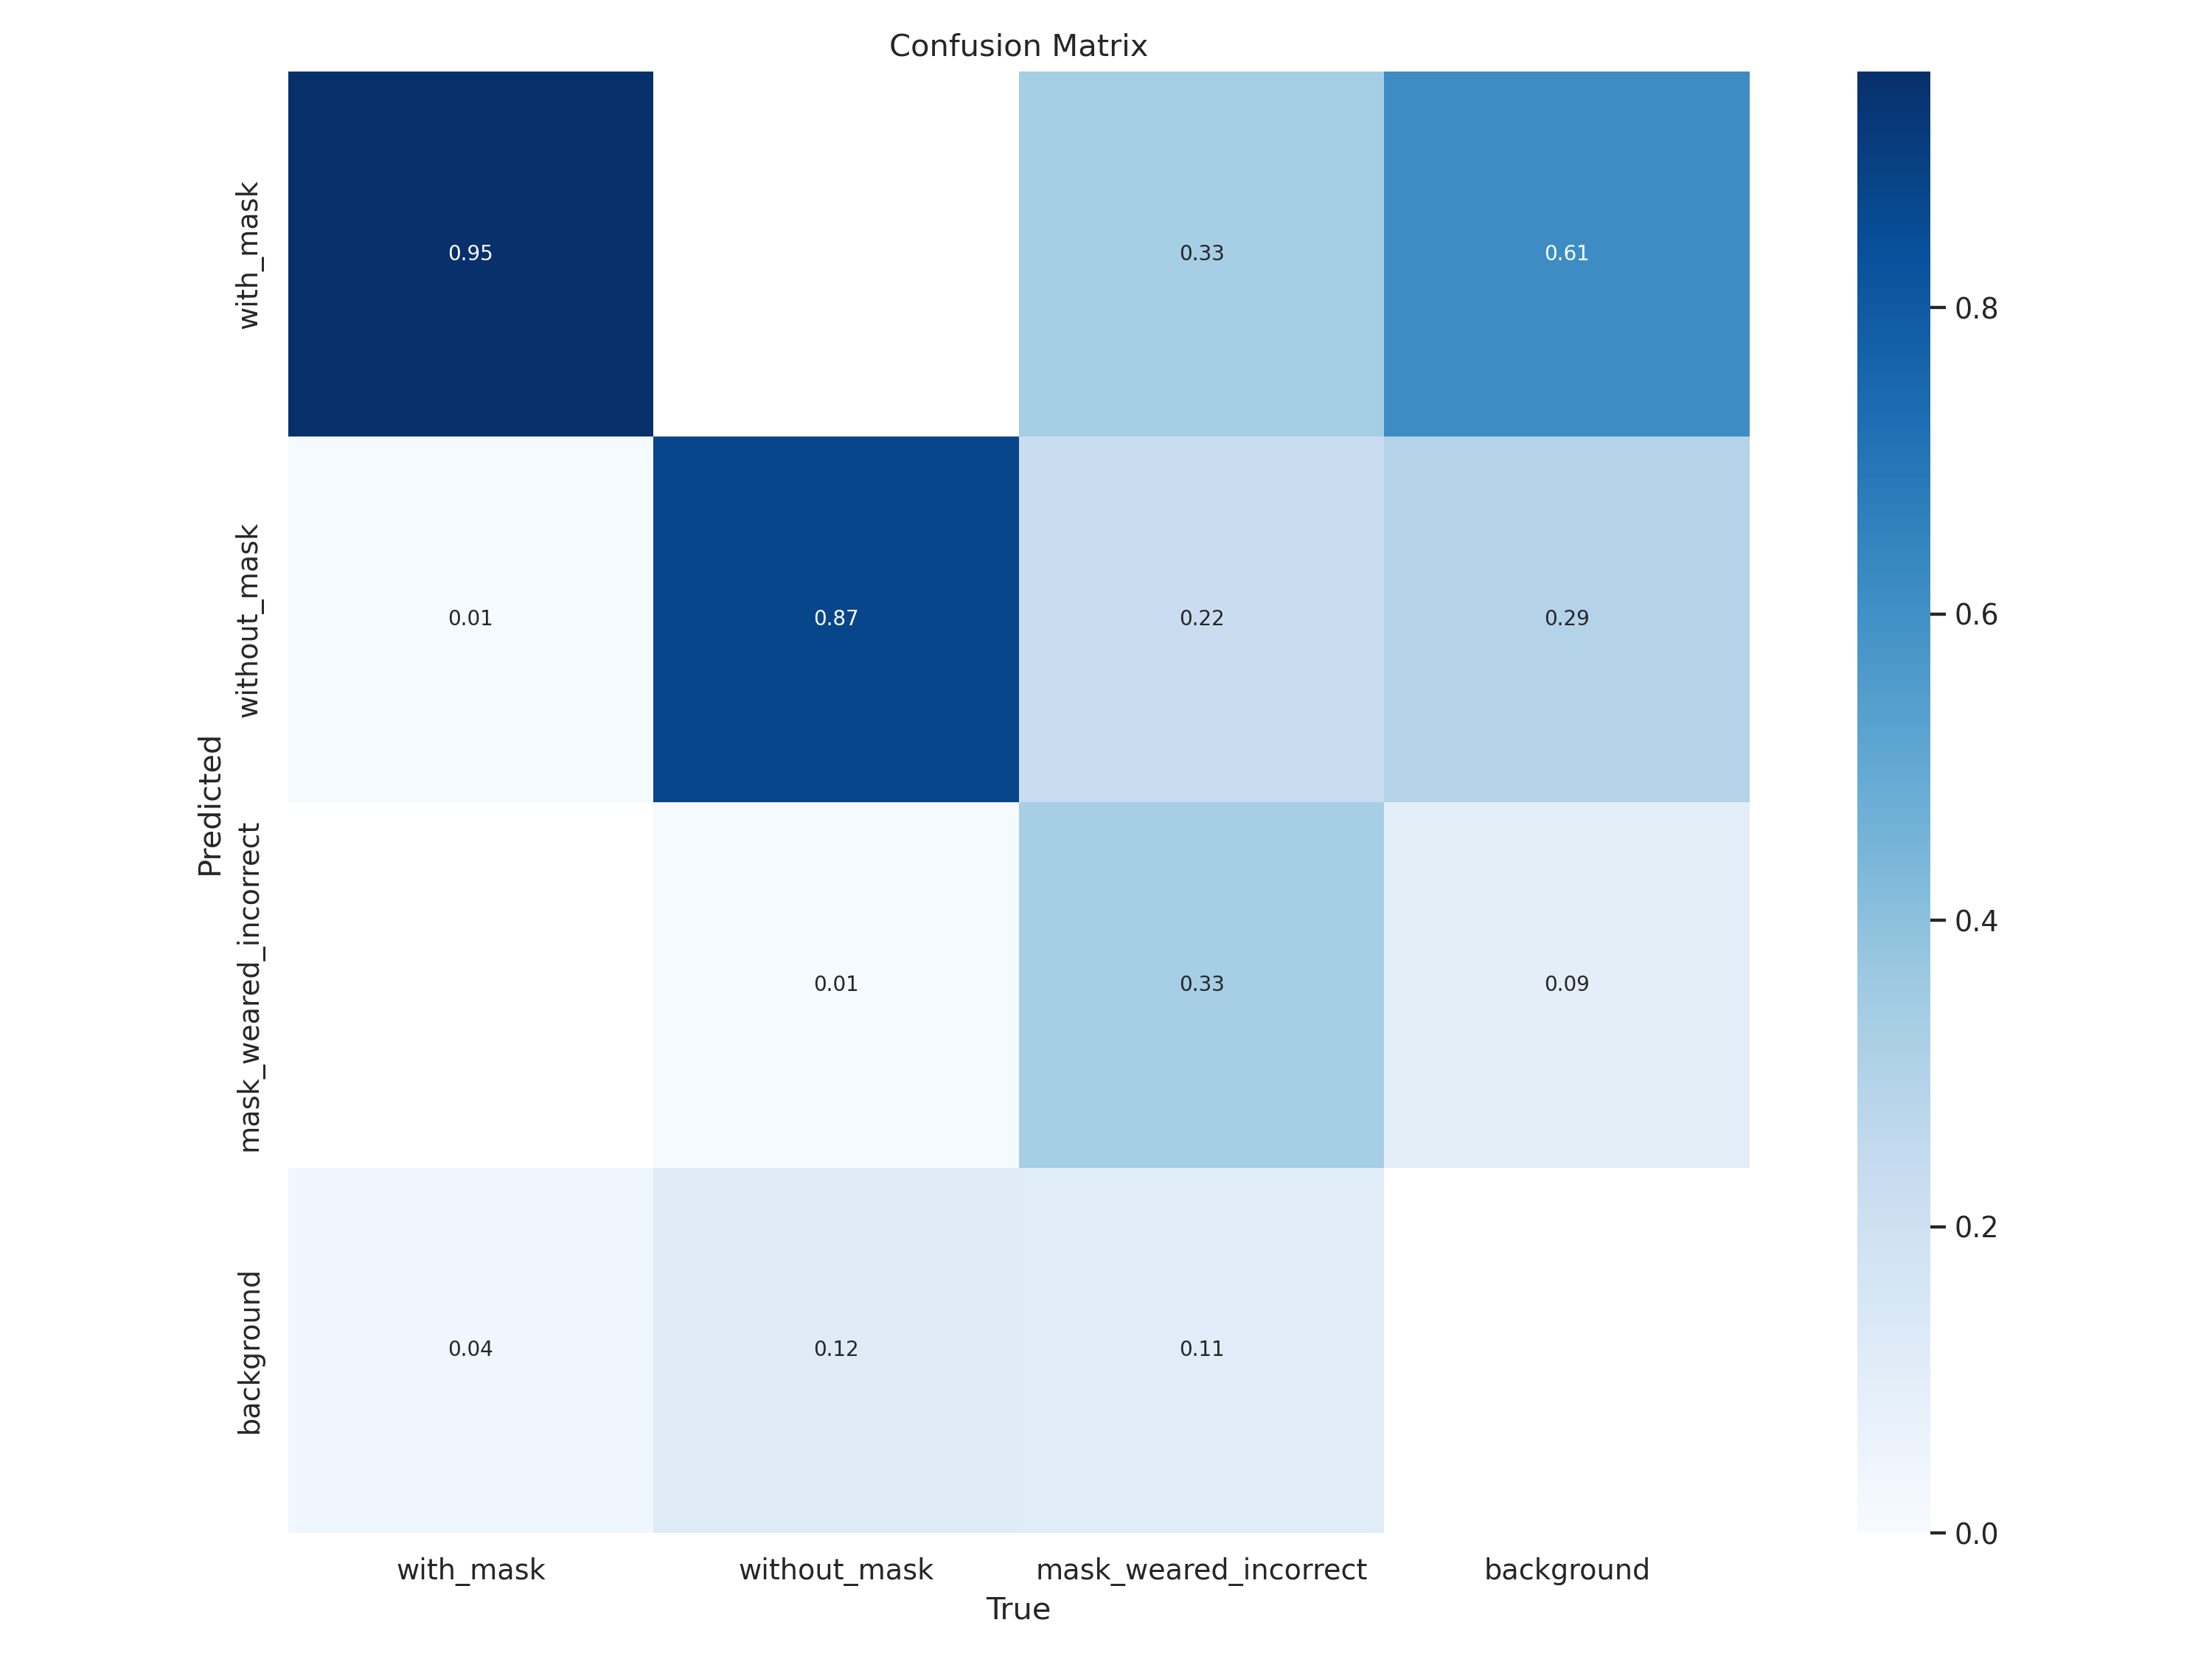

In [56]:
Image(filename = '/kaggle/working/runs/detect/train/confusion_matrix.png')

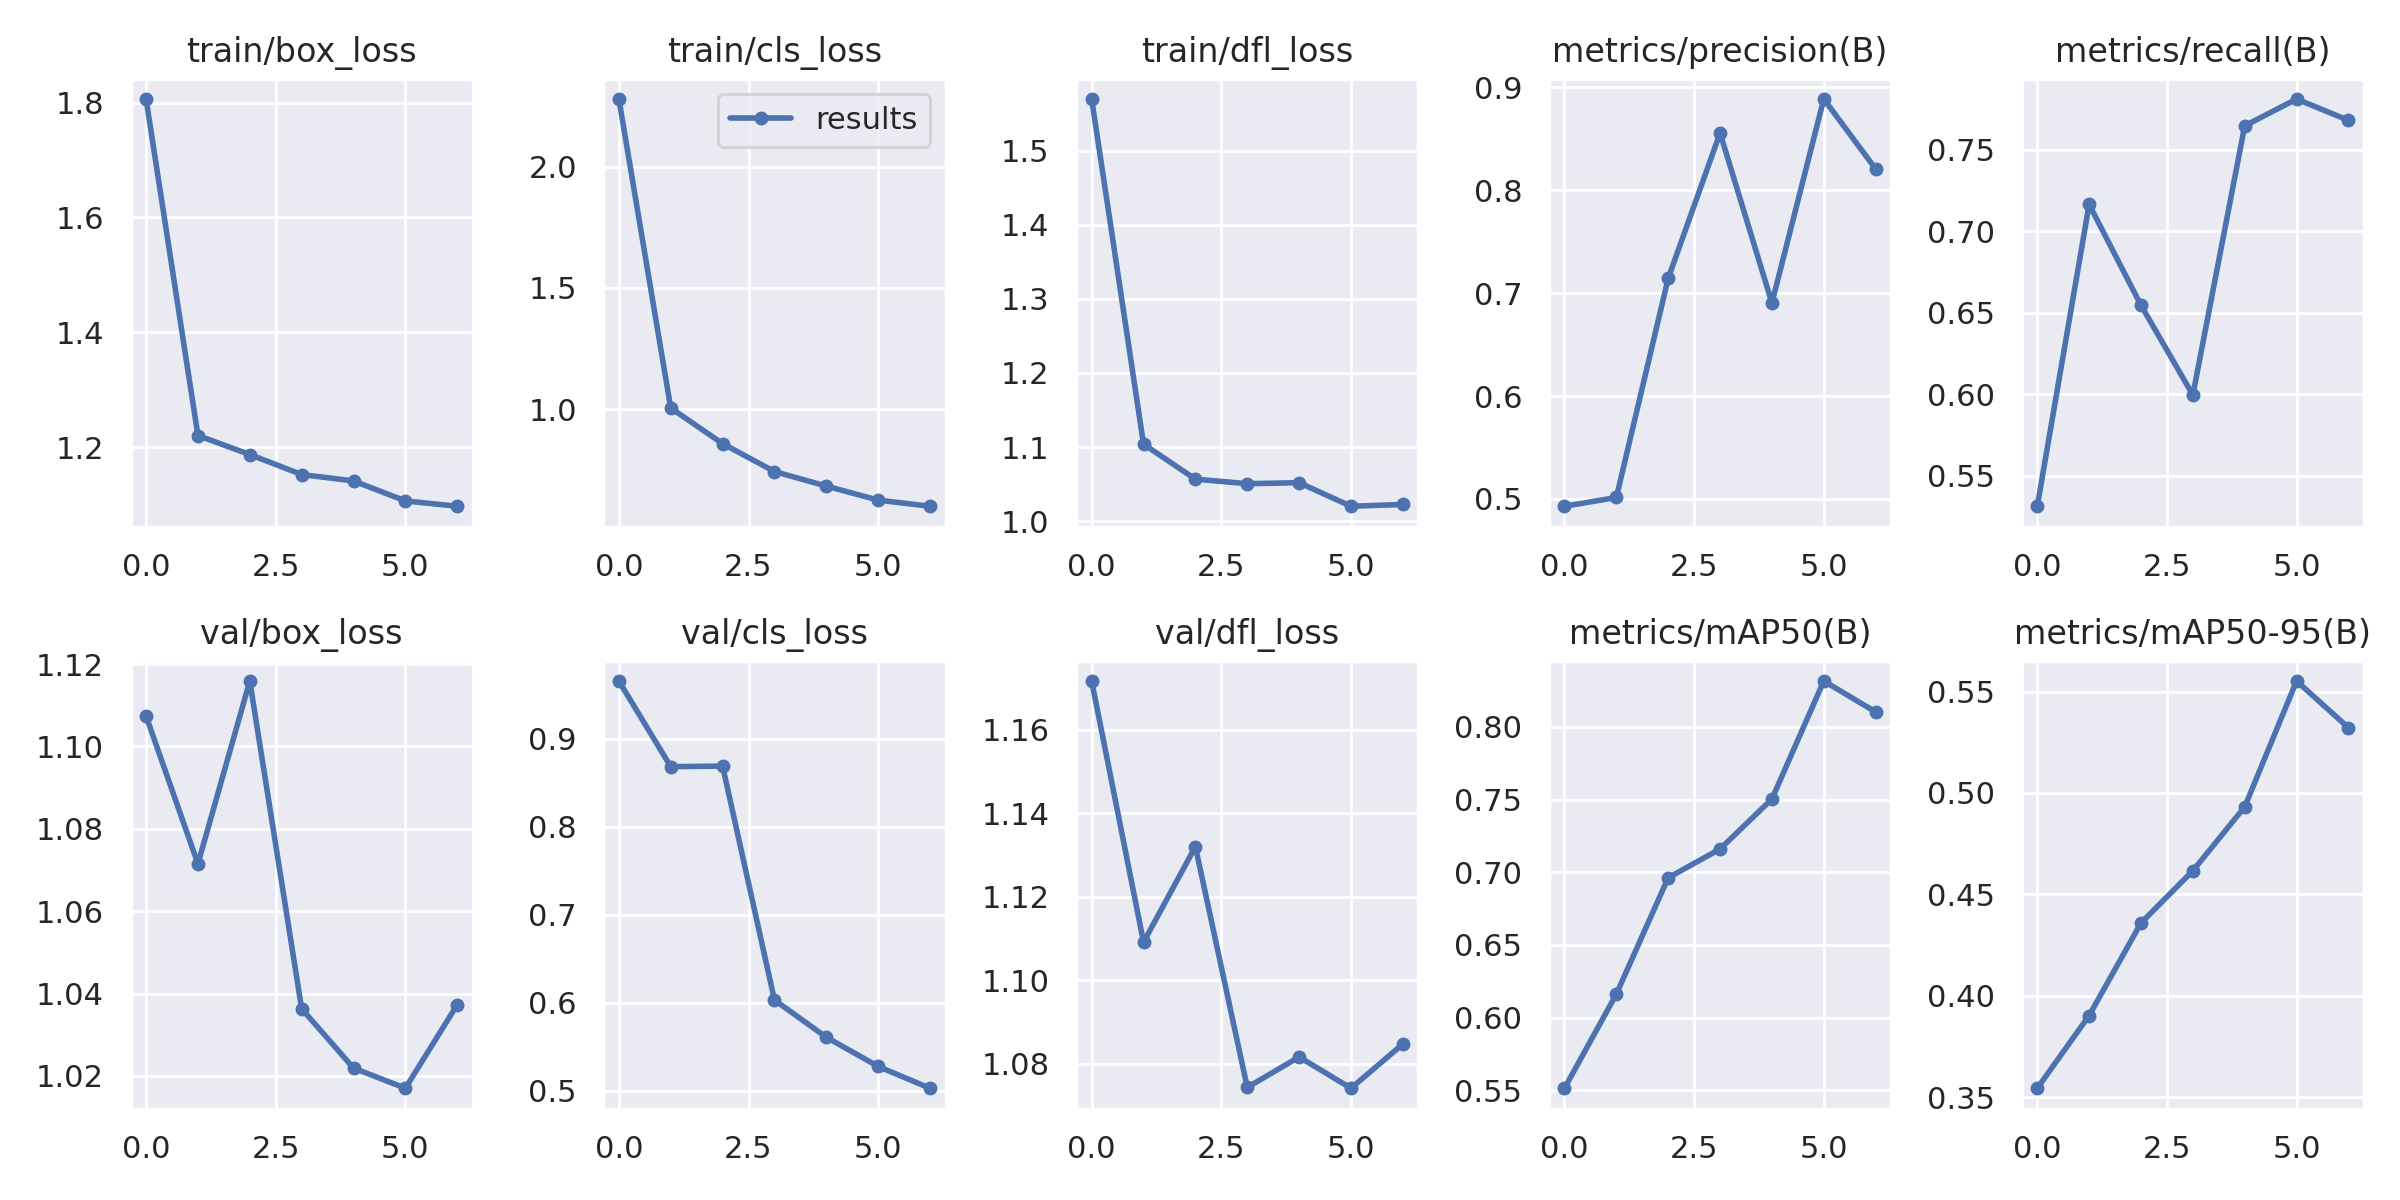

In [57]:
Image(filename = '/kaggle/working/runs/detect/train/results.png')

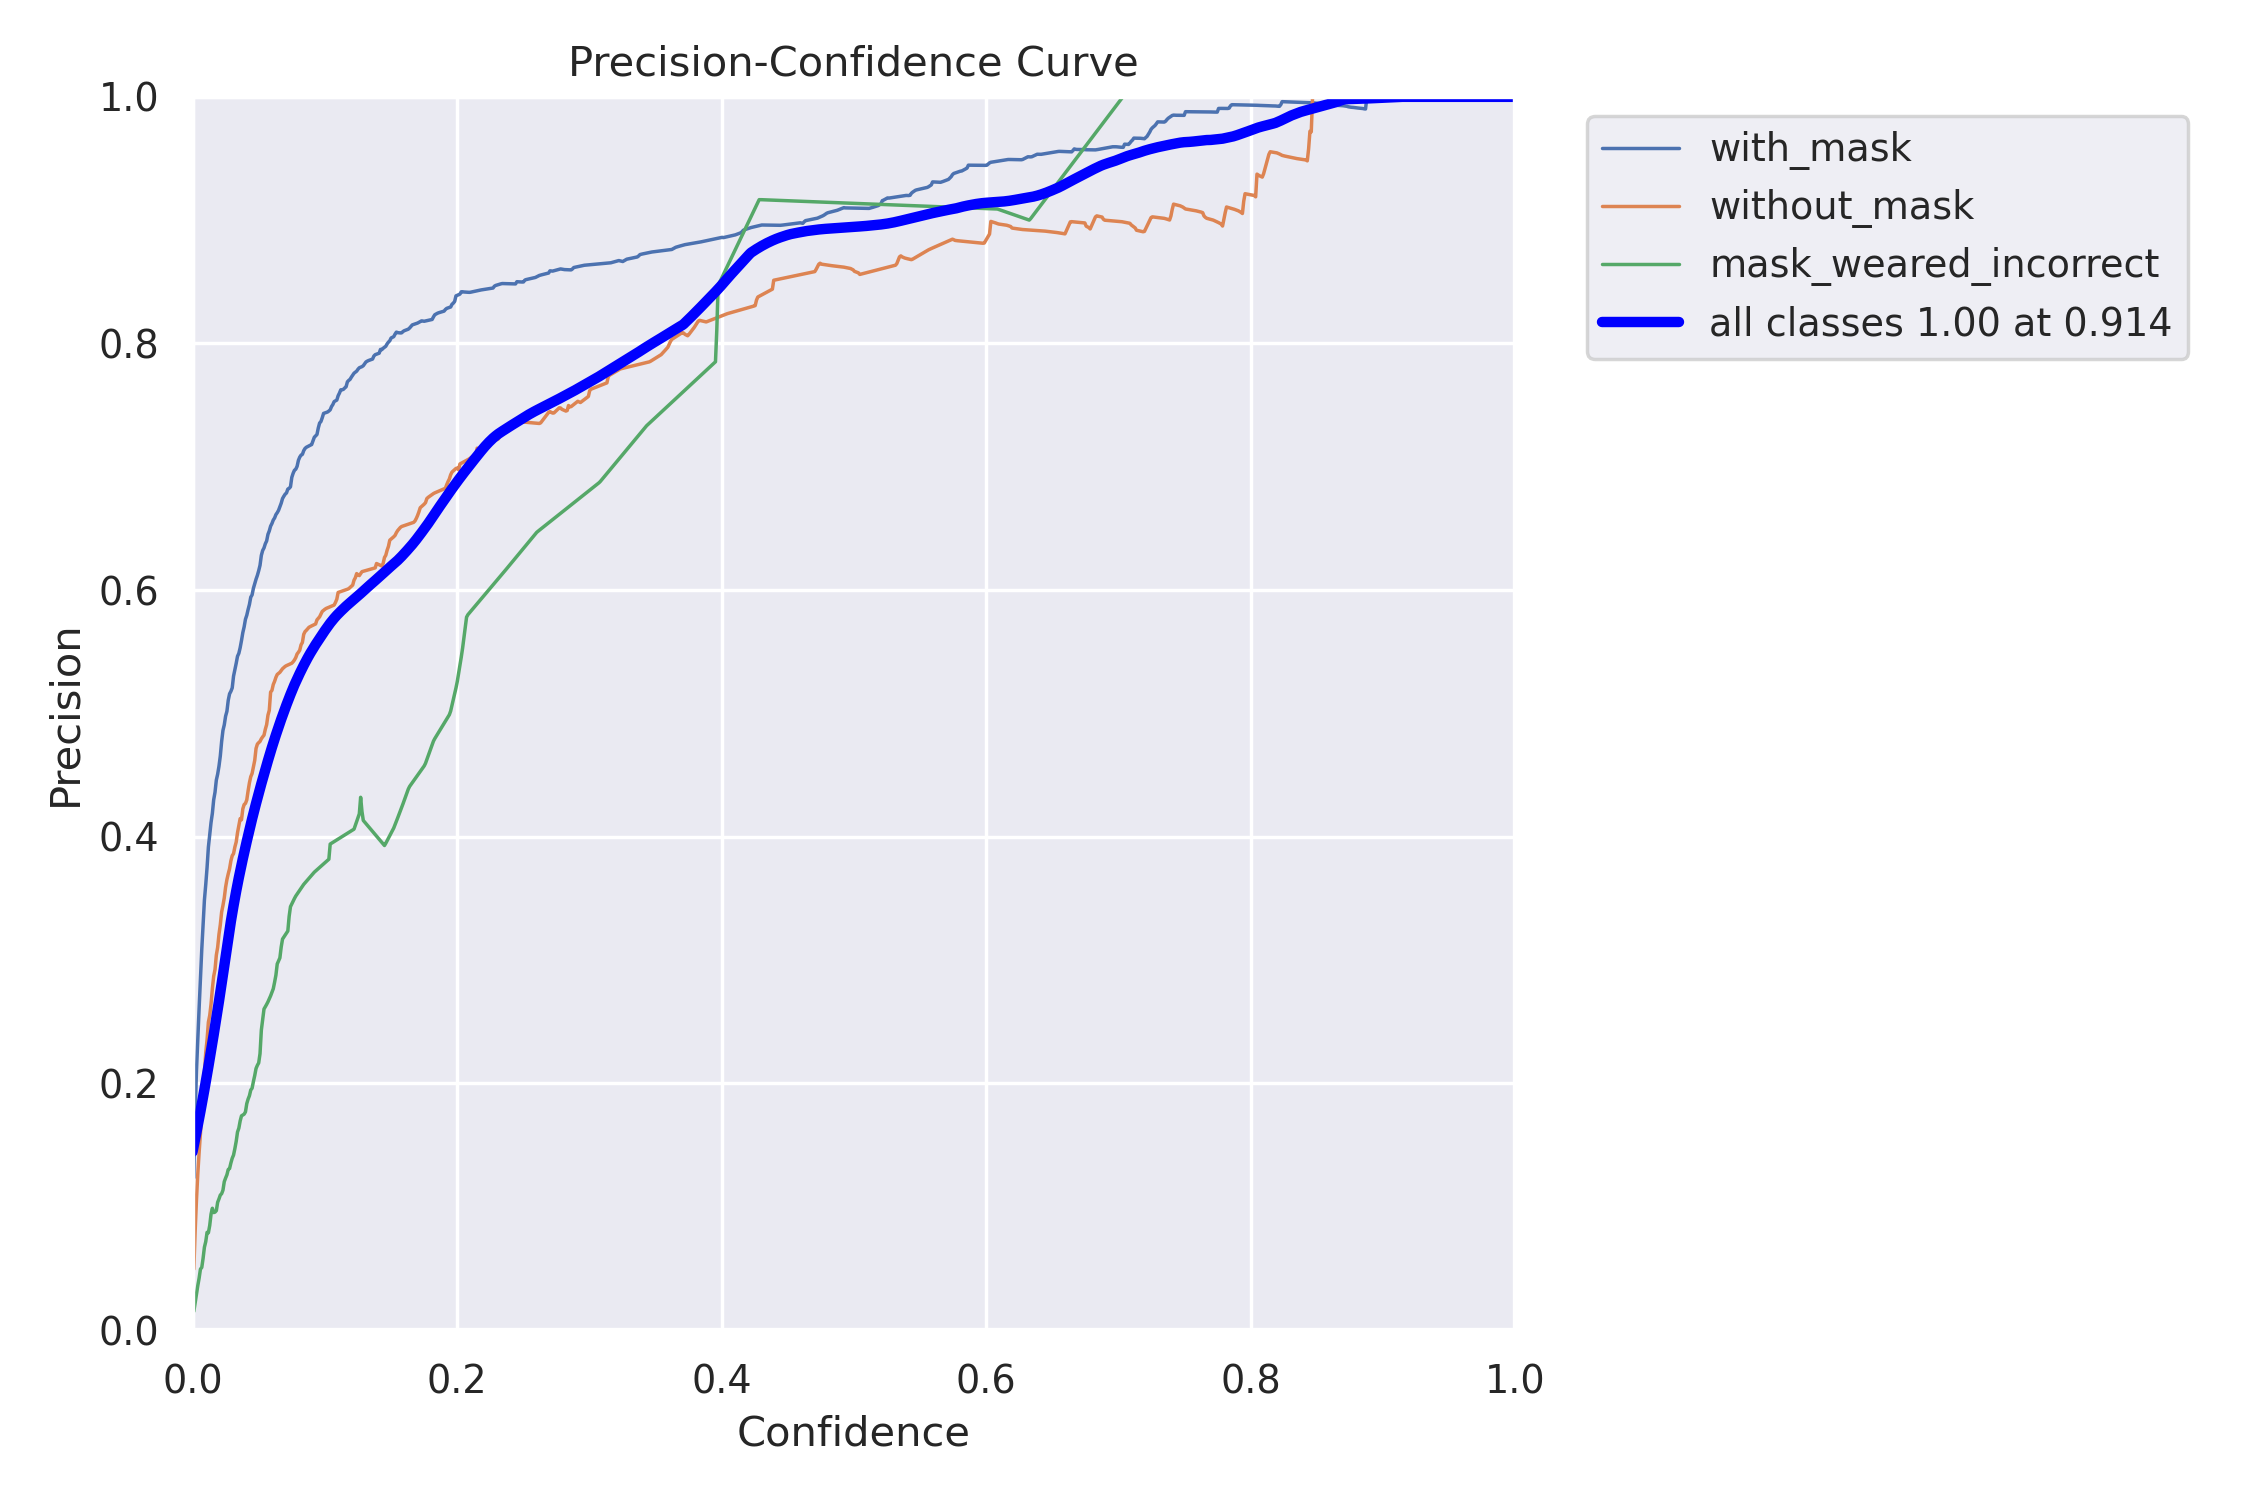

In [88]:
Image(filename = '/kaggle/working/runs/detect/train/P_curve.png')

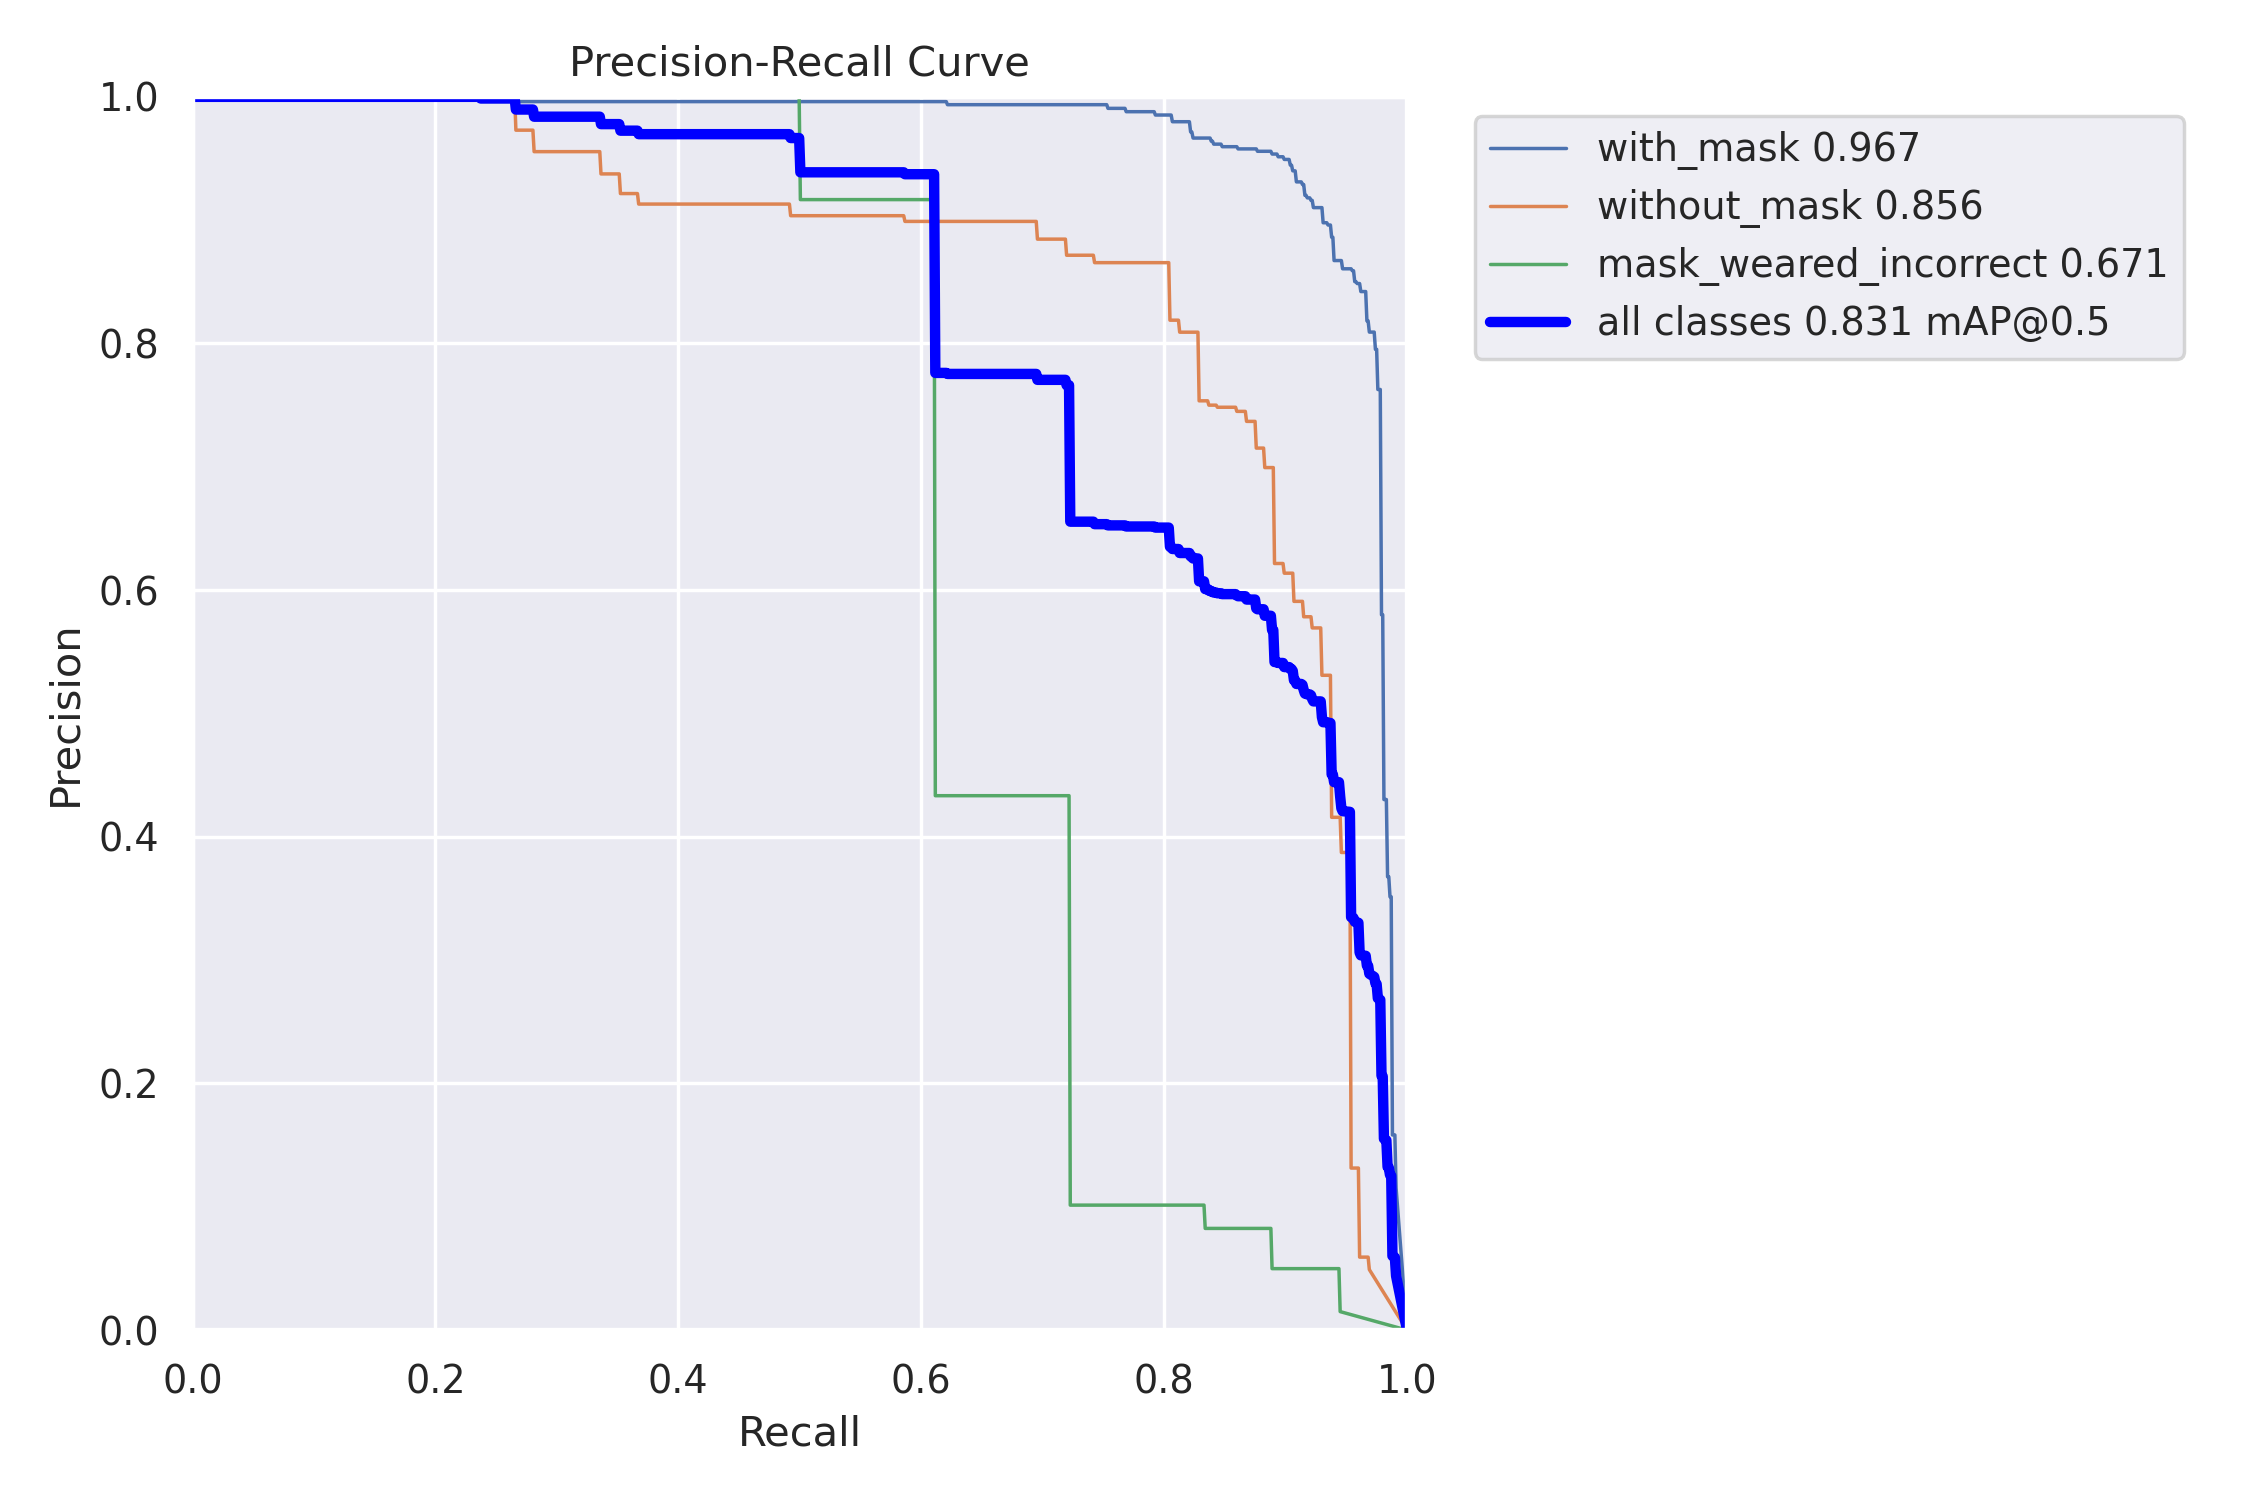

In [78]:
Image(filename = '/kaggle/working/runs/detect/train/PR_curve.png')

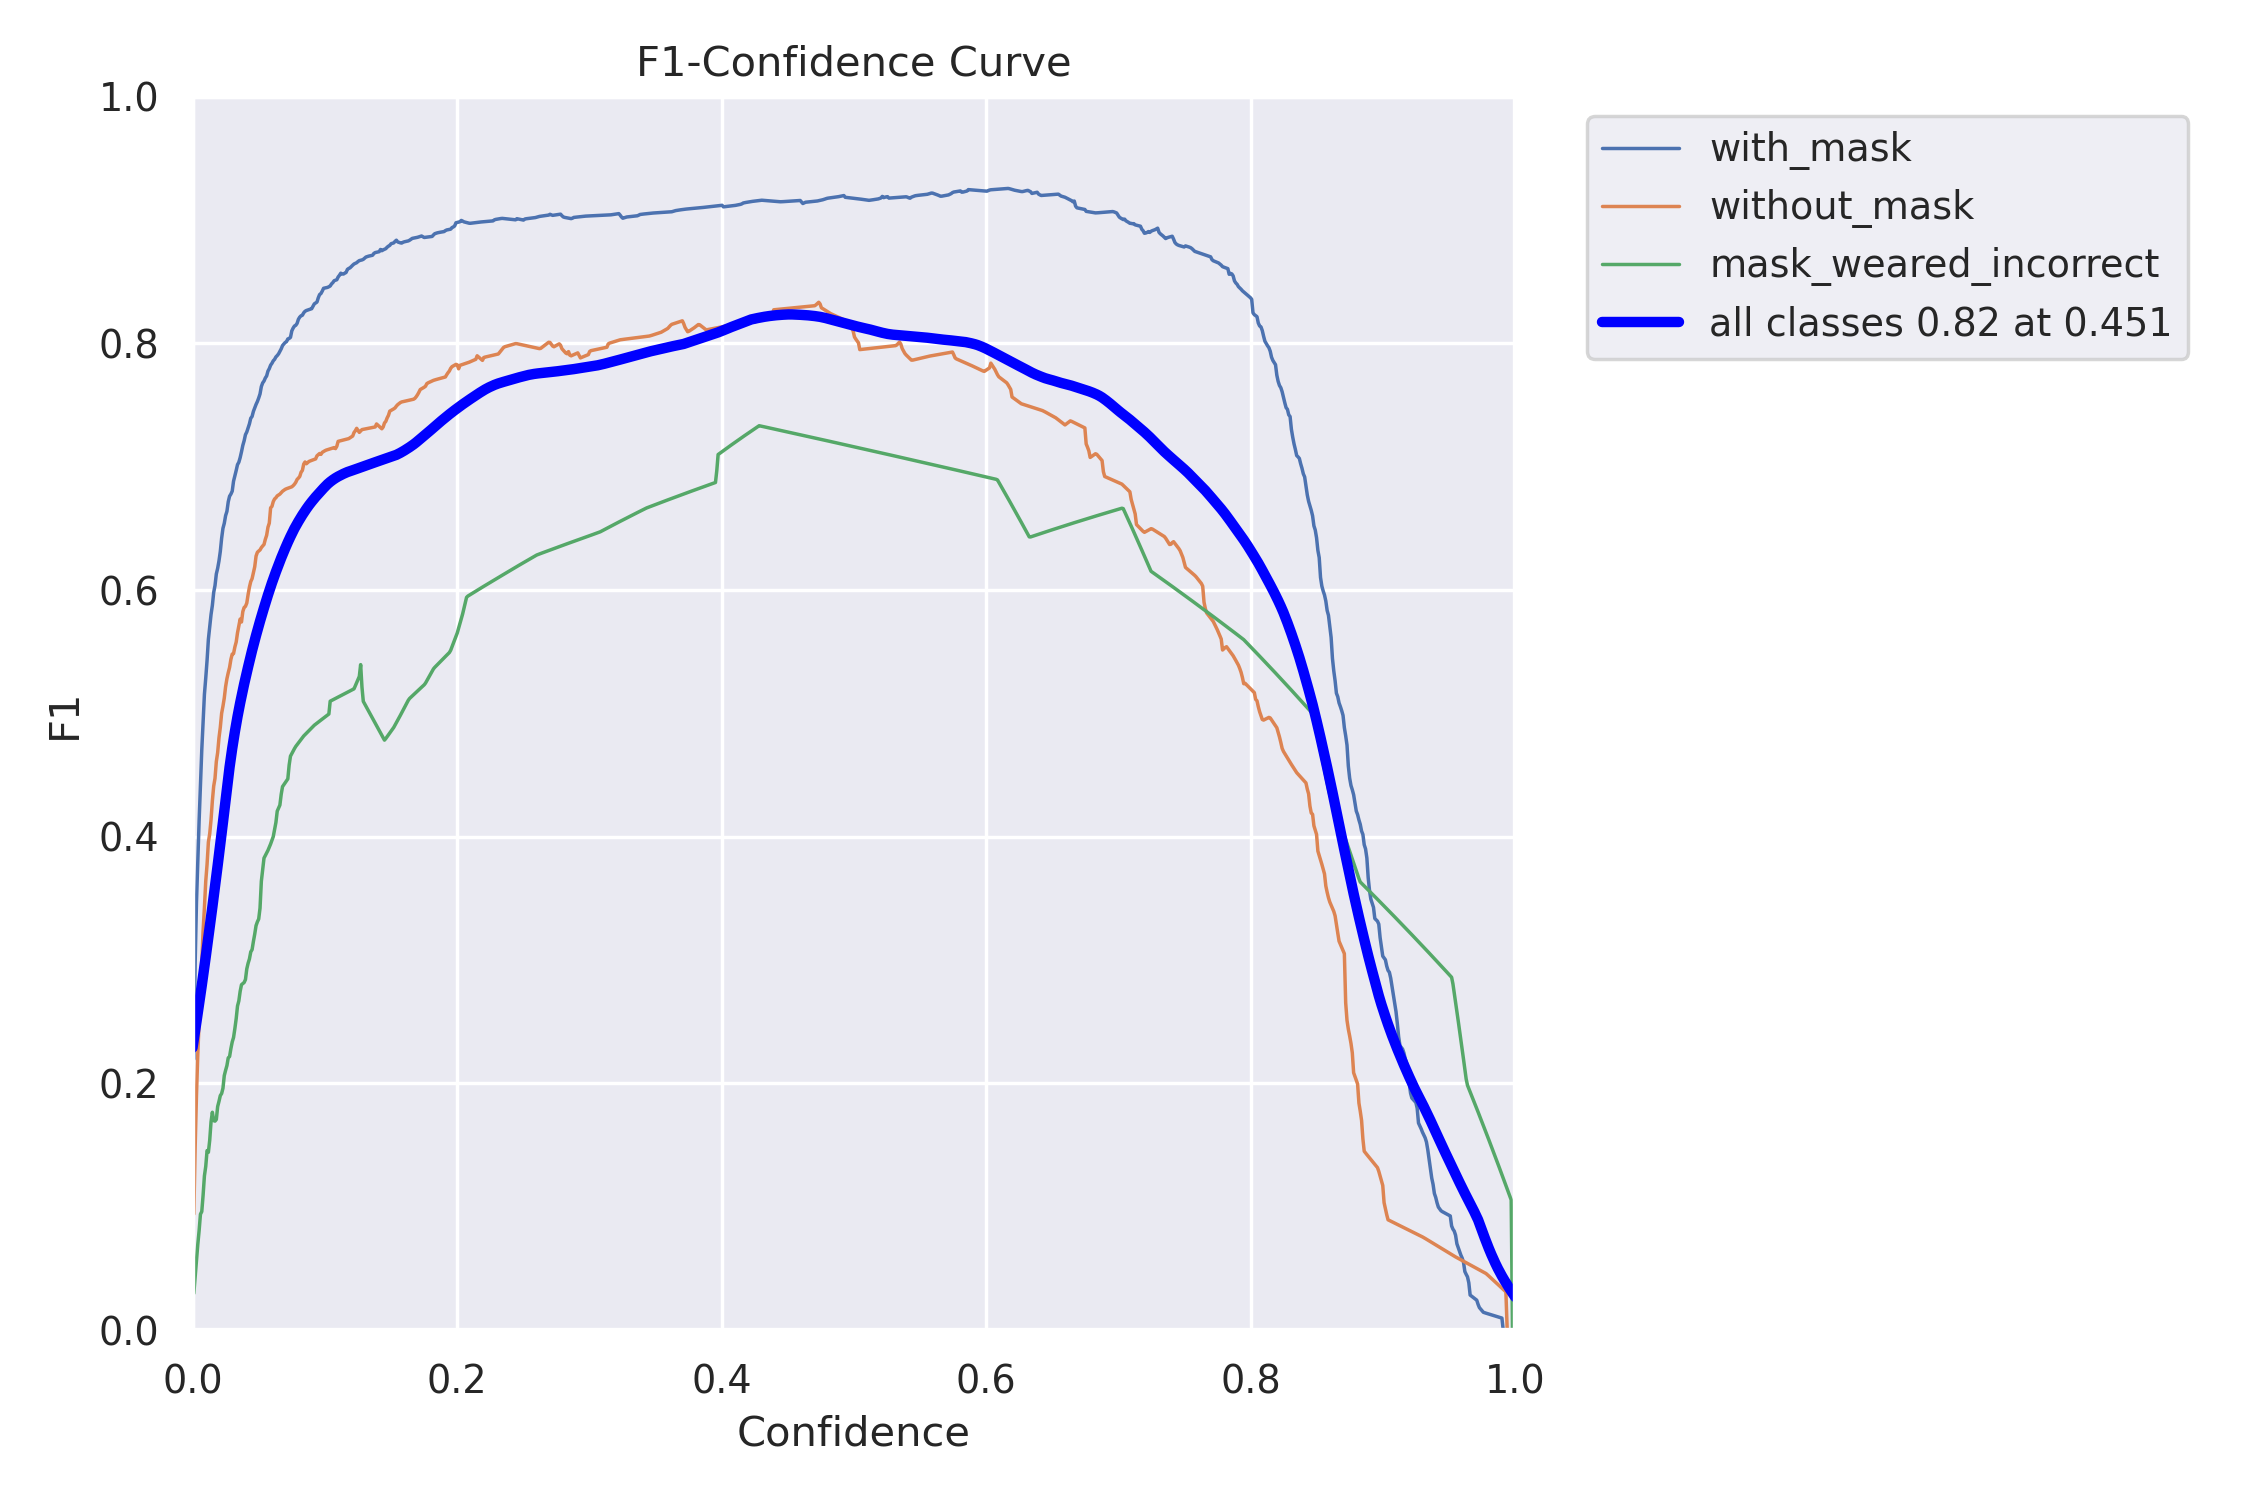

In [77]:
Image(filename = '/kaggle/working/runs/detect/train/F1_curve.png')

### validation

In [105]:
! yolo task=detect mode=val model=/kaggle/working/runs/detect/train/weights/best.pt data=/kaggle/working/Mask_Detection/data_1.yaml

Ultralytics YOLOv8.0.29 🚀 Python-3.7.12 torch-1.13.1 CPU
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /kaggle/working/Mask_Detection/validation/labels.cache... 116 imag
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        116        560       0.89       0.78      0.833      0.555
             with_mask        116        414        0.9      0.932      0.967       0.69
          without_mask        116        128      0.856      0.805      0.857      0.567
 mask_weared_incorrect        116         18      0.916      0.603      0.676      0.409
Speed: 3.7ms pre-process, 2188.5ms inference, 0.0ms loss, 0.7ms post-process per image


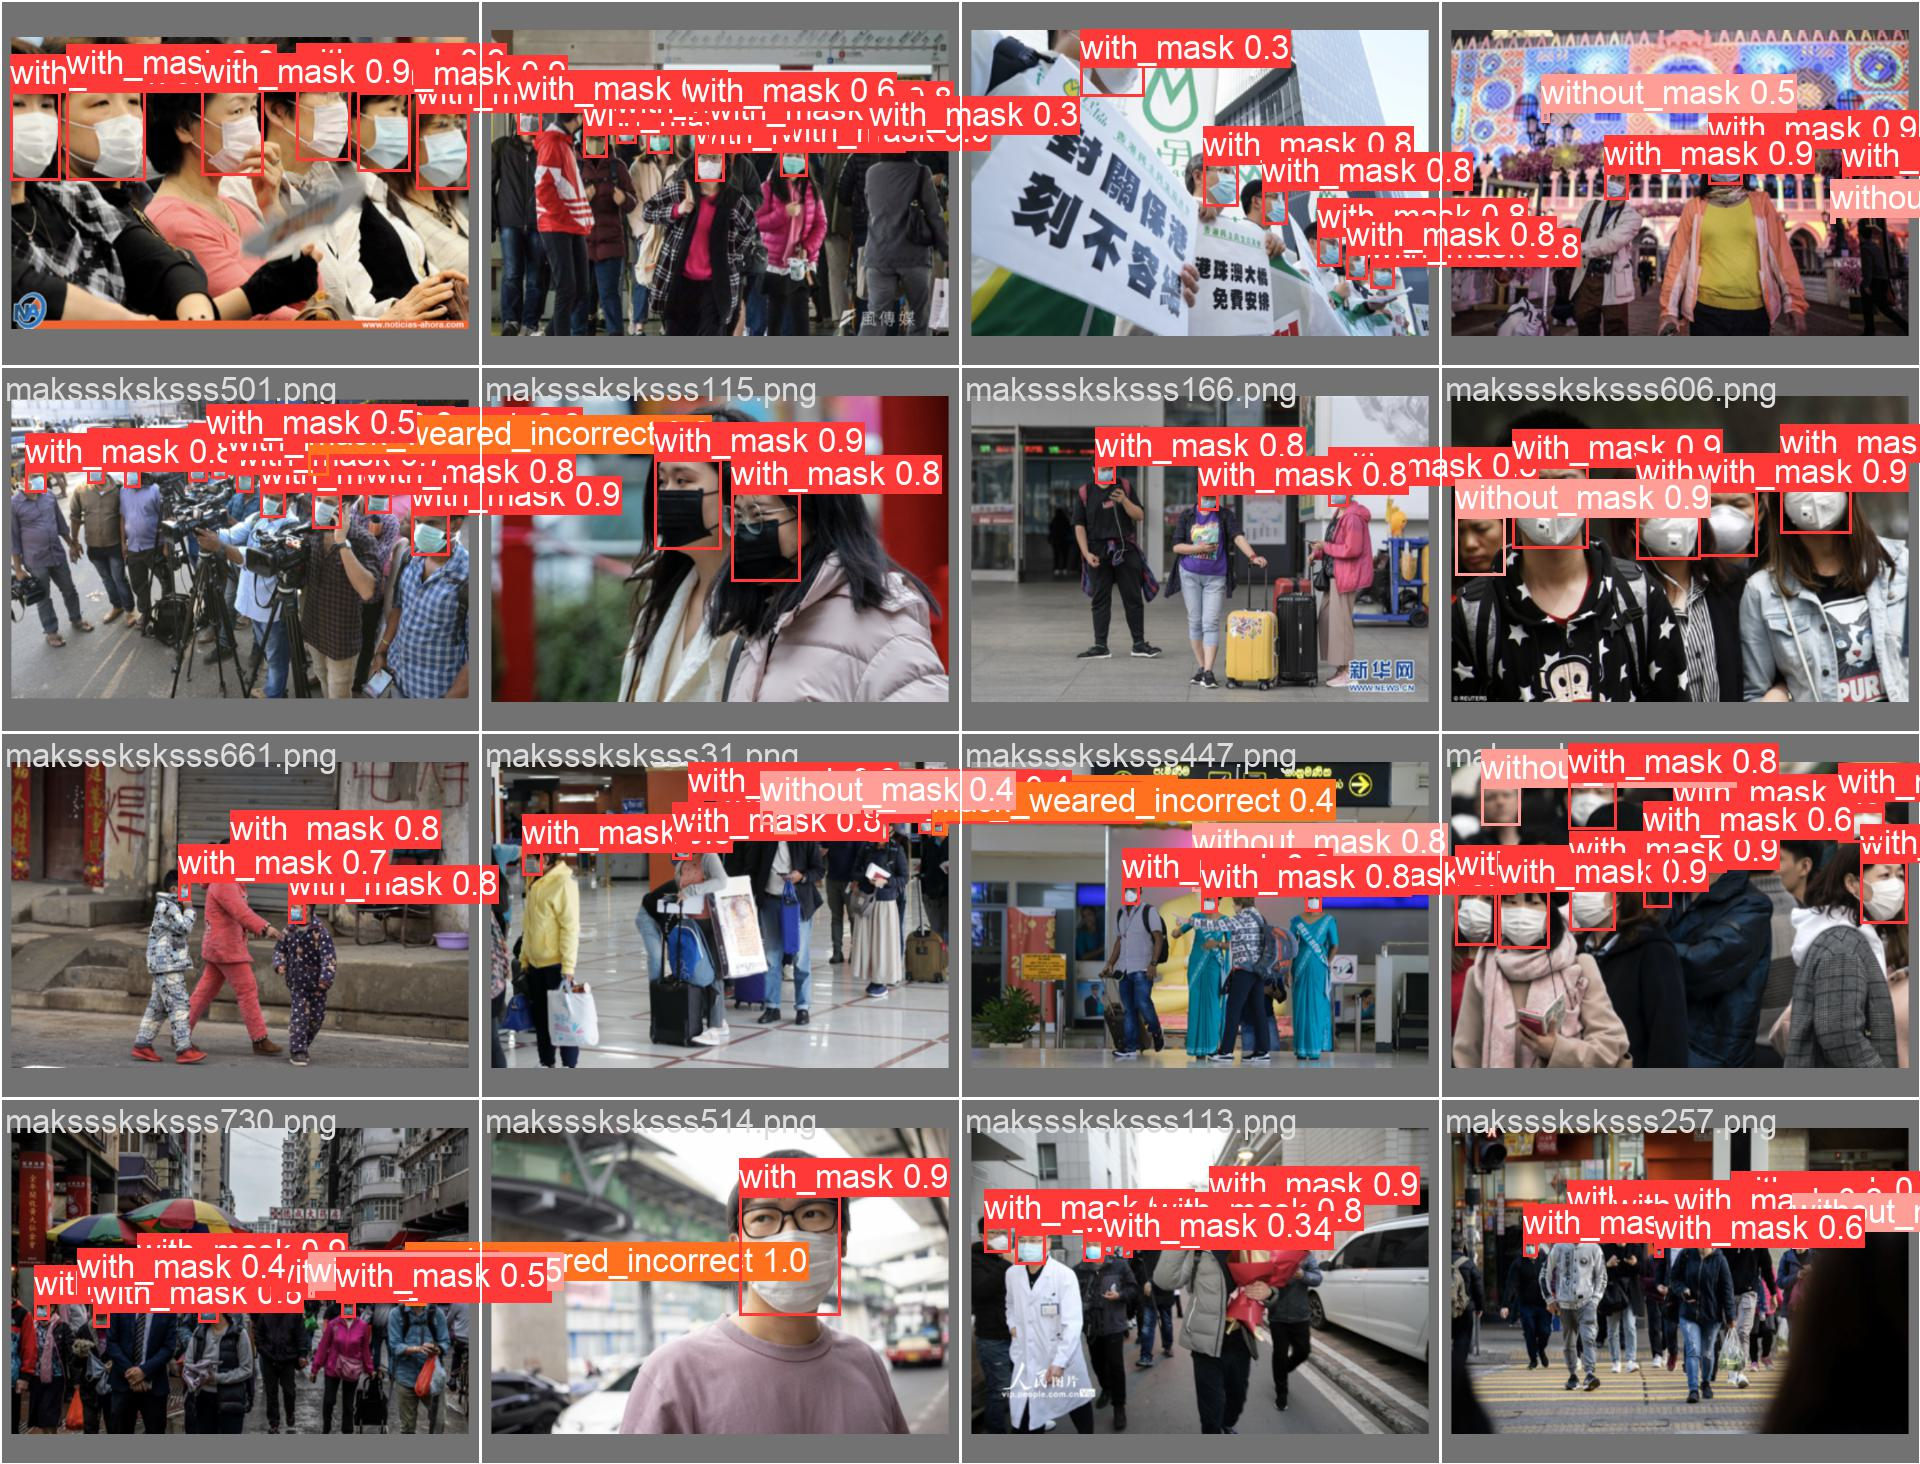

In [85]:
Image(filename = '/kaggle/working/runs/detect/train/val_batch1_pred.jpg')

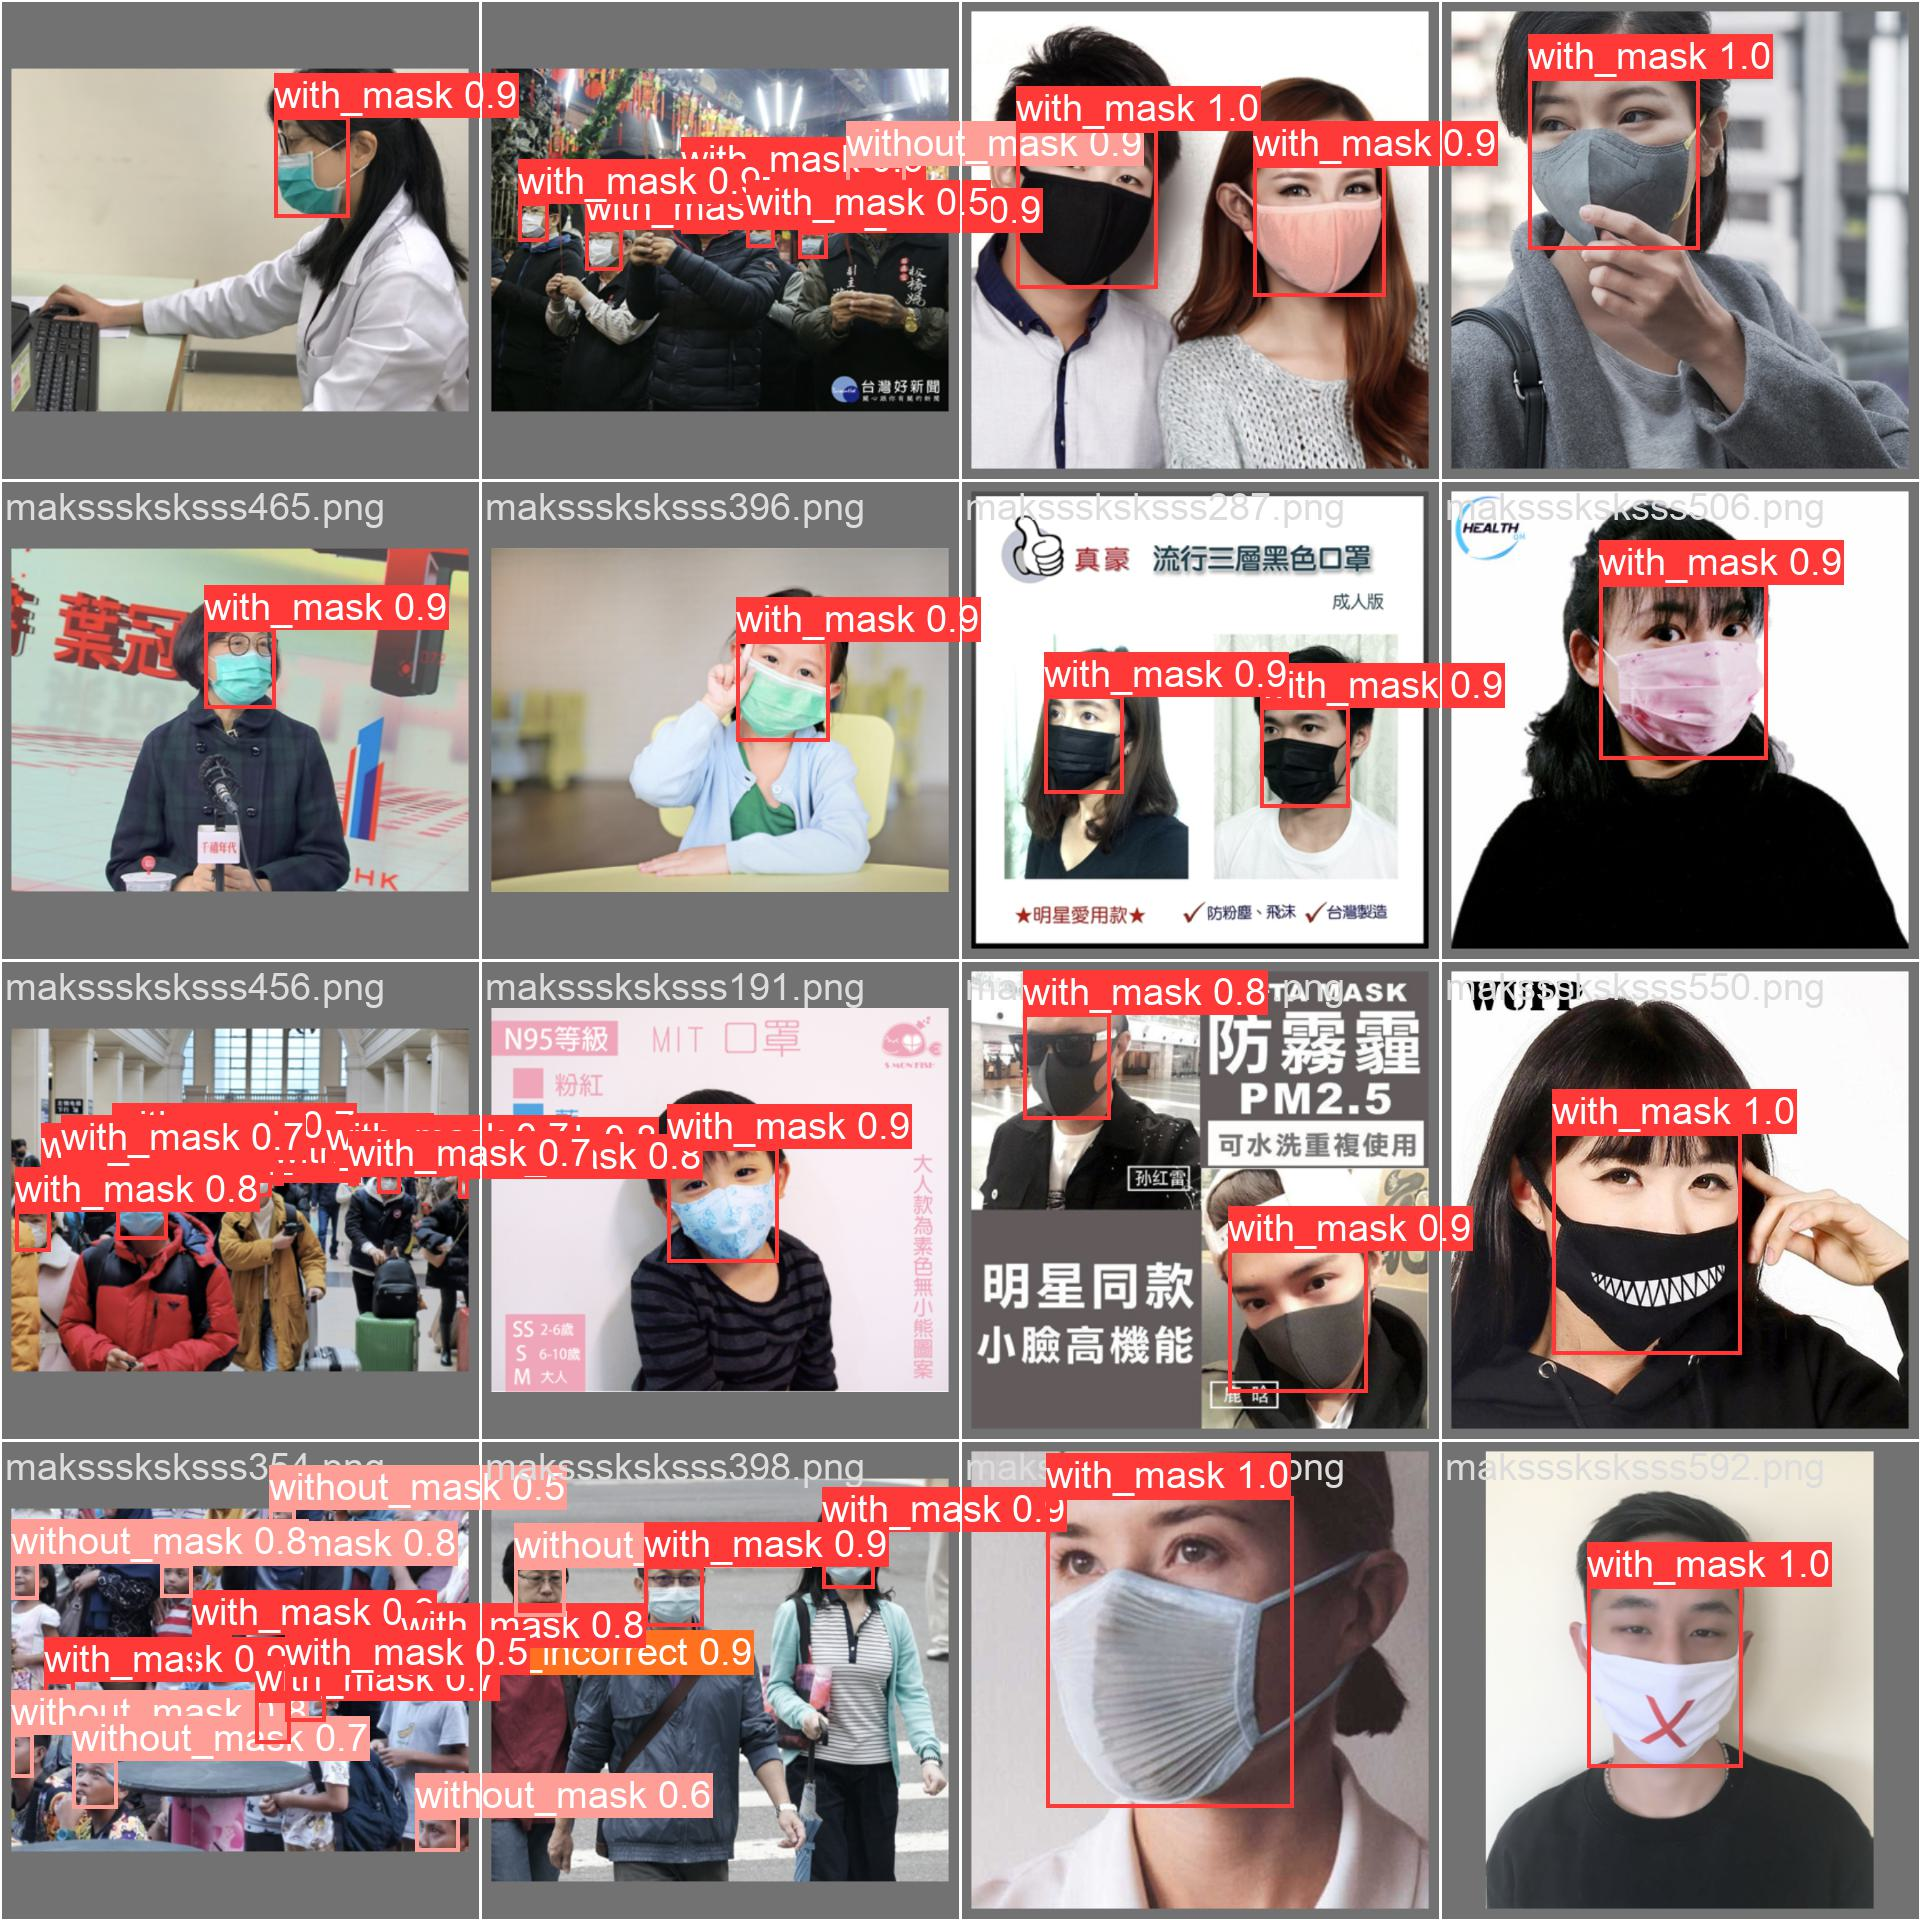

In [84]:
Image(filename = '/kaggle/working/runs/detect/train/val_batch2_pred.jpg')

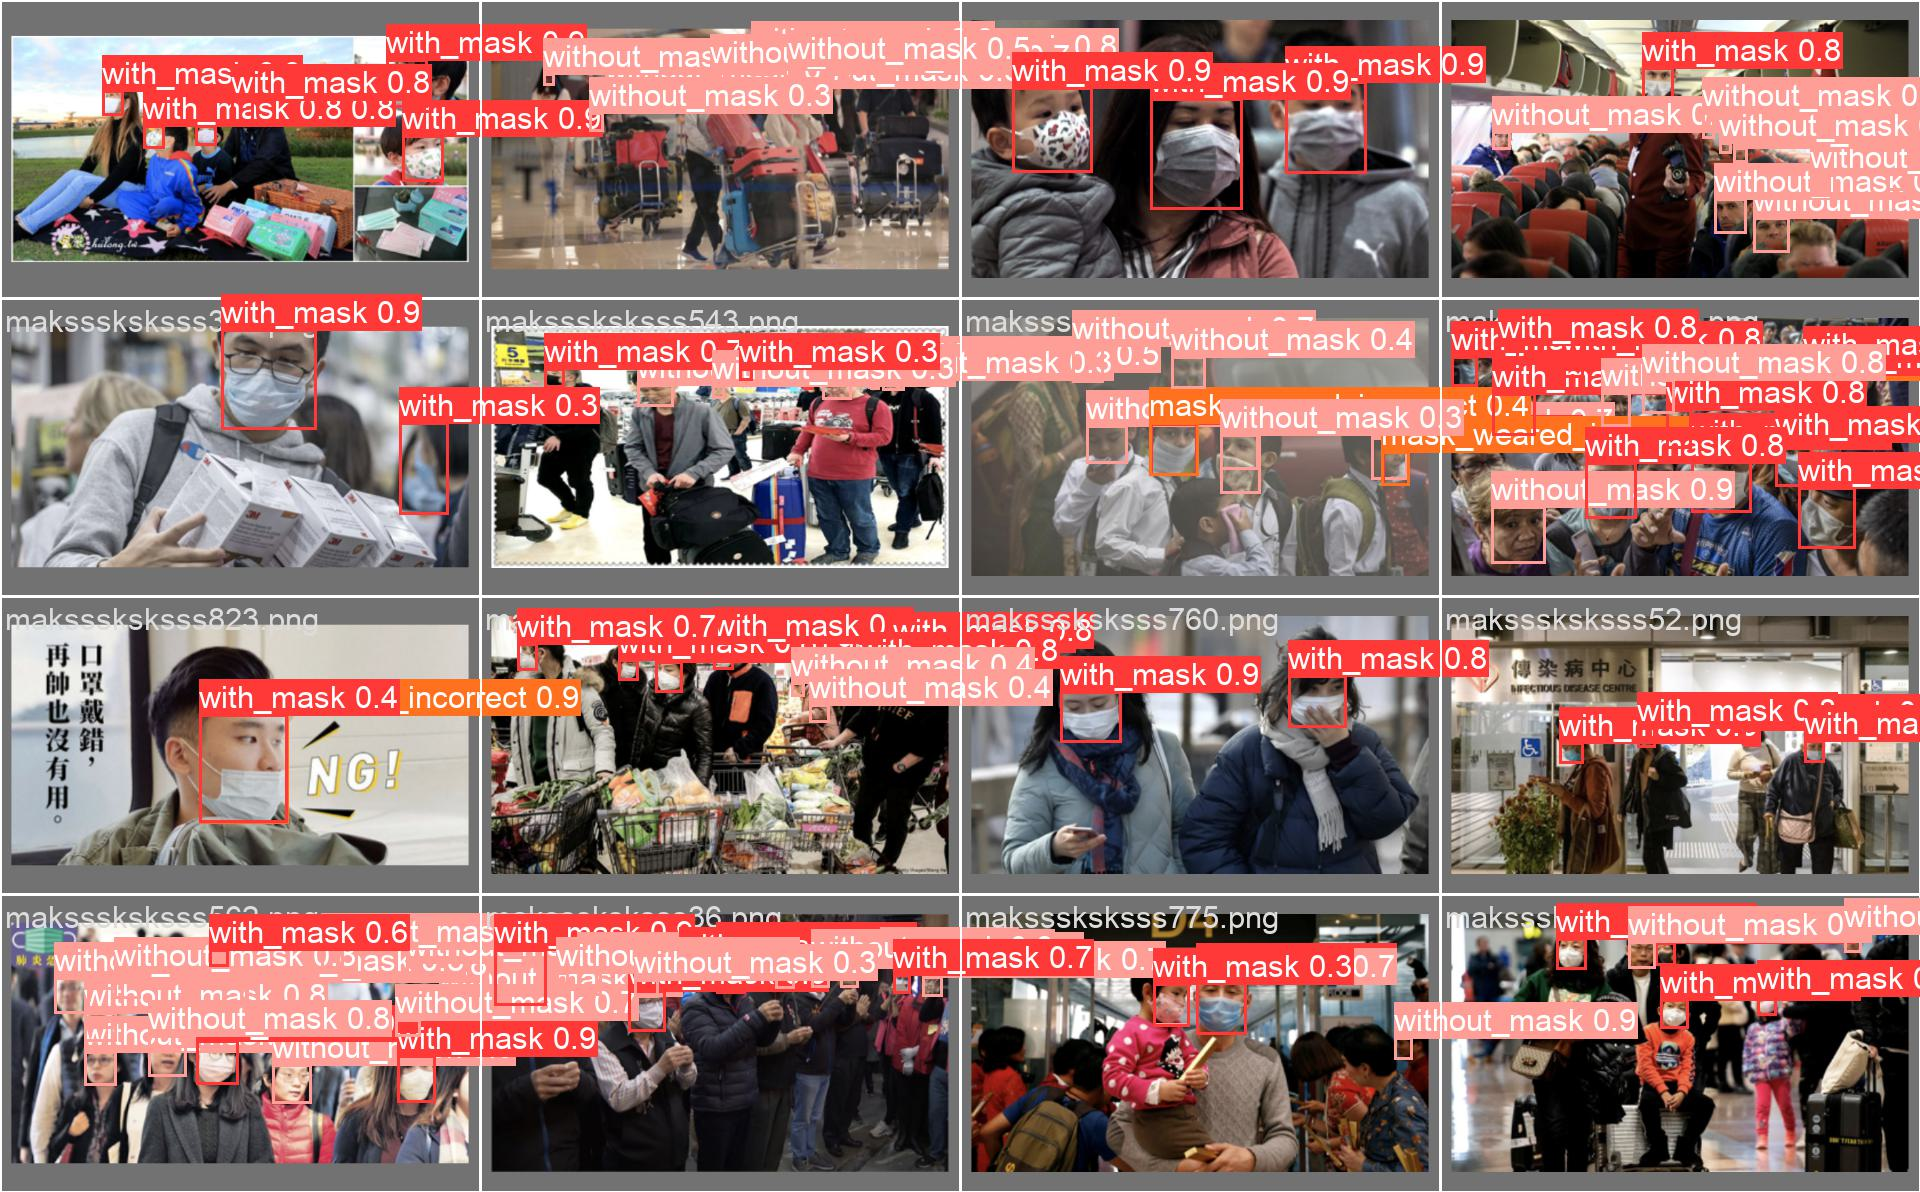

In [107]:
Image(filename = '/kaggle/working/runs/detect/train/val_batch0_pred.jpg')

### make predictions

In [106]:
! yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt conf=0.05 source=/kaggle/working/Mask_Detection/test/images

Ultralytics YOLOv8.0.29 🚀 Python-3.7.12 torch-1.13.1 CPU
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs

image 1/86 /kaggle/working/Mask_Detection/test/images/maksssksksss107.png: 640x512 1 with_mask, 1972.8ms
image 2/86 /kaggle/working/Mask_Detection/test/images/maksssksksss116.png: 384x640 6 with_masks, 1373.1ms
image 3/86 /kaggle/working/Mask_Detection/test/images/maksssksksss123.png: 512x640 2 with_masks, 1838.6ms
image 4/86 /kaggle/working/Mask_Detection/test/images/maksssksksss13.png: 384x640 11 with_masks, 1 without_mask, 2 mask_weared_incorrects, 1358.1ms
image 5/86 /kaggle/working/Mask_Detection/test/images/maksssksksss151.png: 320x640 12 with_masks, 3 without_masks, 1182.6ms
image 6/86 /kaggle/working/Mask_Detection/test/images/maksssksksss153.png: 448x640 1 with_mask, 1 without_mask, 1626.2ms
image 7/86 /kaggle/working/Mask_Detection/test/images/maksssksksss187.png: 480x640 5 with_masks, 1714.9ms
image 8/86 /kaggle/working/Mask_Detection/te